In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from matplotlib import cm
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

# fix gpu memory management 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# enable reproducibility
SEED = 42
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Loading and normalizing the dataset

In [2]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

# Visualizing some samples

In [3]:
def preview(size):
    labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    fig, ax = plt.subplots(size, size)
    for i in range(size):
        for j in range(size):
            idx = np.random.choice(len(x_train))
            ax[i, j].imshow(x_train[idx])
            ax[i, j].axis('off')
            ax[i, j].set(title=labels[y_train[idx, 0]])

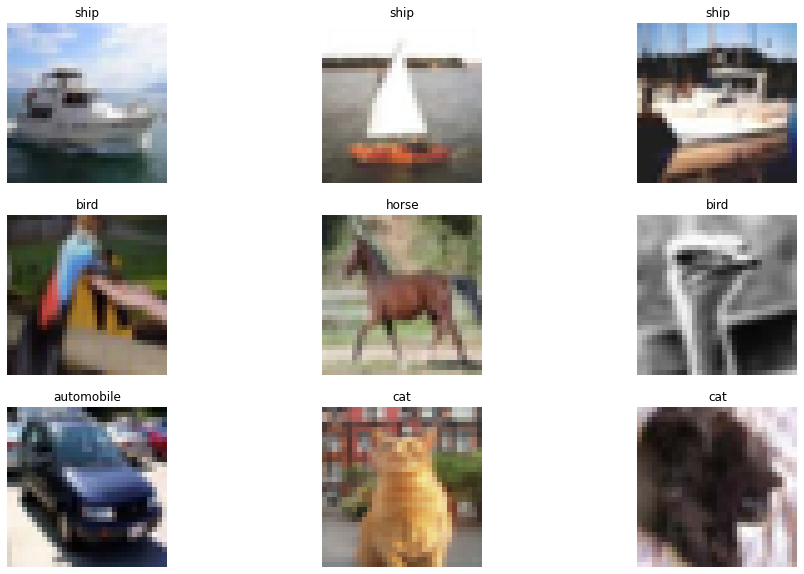

In [4]:
preview(3)

# Training a baseline model

In [5]:
from src.model import SimpleNet

model = SimpleNet()

train_parameters = {
    'steps_per_epoch' : None,
    'epochs' : 50,
    'validation_data' : (x_test,y_test),
    'batch_size' : 100
}

MODEL_NAME = '50epochs_baseline'
TRAINING = False
SAVING = False

if TRAINING:
    model.fit(x_train, y_train, **train_parameters)
if SAVING:
    model.save_weights(f'models/{MODEL_NAME}/model')
    model.save_training_plot(f'img/{MODEL_NAME}.svg')
    model.save_training_history(f'training_history/{MODEL_NAME}.csv')

# Evaluate the signature hit after training

To validate the proof of work, we want to prevent transfer learning as much as possible. Here, we visualize the accuracy of a pretrained model after signing it. We observe an exponential decay with the percentage of signed neurons.

In [6]:
def signature_hit(baseline):
    hit = {
        'signature_size' : [],
        'model_ratio' : [],
        'accuracy' : [],
        'f1' : [],
        'loss' : [],
    }
    
    model_ratio = np.linspace(0, 0.1, 50)

    for ratio in tqdm(model_ratio):
        model = SimpleNet()
        model.load_weights(baseline).expect_partial()
        
        sig_size = int(ratio*model.n_weights())
        signature = Signature(b'Some block information', sig_size)
        signature.sign(model)
        assert signature.verify(model)
        loss, acc, f1 = model.evaluate(x_test, y_test, verbose=0)
        
        hit['model_ratio'].append(ratio)  
        hit["signature_size"].append(sig_size)
        hit['accuracy'].append(acc)
        hit['f1'].append(f1)
        
    return hit

In [7]:
from scipy.optimize import least_squares

def exp(t, a, b, c):
    return  a + b * np.exp(t * c)

def fun(x, t, y):
    return x[0] + x[1] * np.exp(x[2] * t) - y

def exp_fit(x, y):
    x0 = np.array([1.0, 1.0, 0.0])
    return least_squares(fun, x0, loss='soft_l1', args=(x, y)).x

def fit_hit(data):
    sol = exp_fit(data["model_ratio"], data["accuracy"])

    fig, ax = plt.subplots()
    
    ax.scatter(metrics["model_ratio"], metrics["accuracy"], label='Accuracy on test set')
    ax.plot(x, decay(metrics["model_ratio"], *sol), label=f'{sol[0]:.1} + {sol[1]:.1} $e^{{{sol[2]:.0f}r}}$')
    ax.set(xlabel='Signature size / # of model parameters', ylabel='Accuracy', title="Pretrained model accuracy after applying signature")
    ax.legend(loc="upper right")
    
    return fig

In [8]:
SAVING = False

if SAVING:
    metrics = signature_hit(f'models/{MODEL_NAME}/model')
    pd.DataFrame(metrics).to_csv(f'signature_hit/{MODEL_NAME}.csv')
    fig = fit_hit(metrics)
    fig.savefig(f'signature_hit/after_training.svg')

# Evaluate the signature hit during training

While it is important that a signed pretrained model does not perform well, we must also show that model can be trained with the signature. 

In [9]:
from src.signature import Signature

TRAINING = False
SAVING = False

model_ratio = np.linspace(0.1, 1.0, 10)
for ratio in model_ratio:
    model = SimpleNet()
    signature_length = int(model.n_weights() * ratio)
    sig = Signature(b'Some block information', signature_length)

    if TRAINING:
        model.fit(x_train, y_train, **train_parameters, signature=sig)
    if SAVING:
        model.save_training_history(f'training_history/sig_{ratio:1f}.csv')

# Checking signatures

We show how models can be checked against a signature.

In [10]:
f = lambda x : "Verified" if x else "Not verified"

model = SimpleNet()

sig = Signature(b'Some block information', 4096)
other_sig = Signature(b'Some other block information', 4096)

sig.sign(model)

print(f"Checking model against original signature : {f(sig.verify(model))}")
print(f"Checking model against another signature : {f(other_sig.verify(model))}")

other_sig.sign(model)

print(f"Checking model against original signature : {f(sig.verify(model))}")
print(f"Checking model against another signature : {f(other_sig.verify(model))}")

Checking model against original signature : Verified
Checking model against another signature : Not verified
Checking model against original signature : Not verified
Checking model against another signature : Verified


# Plotting results

In [11]:
def plot_results(scatter=False):
    fig, ax = plt.subplots(1, 2)
    colormap = cm.cividis_r
    model_ratio = np.linspace(0.1, 1.0, 10)
    
    for ratio in model_ratio:
        data = pd.read_csv(f'training_history/sig_{ratio:.1f}.csv')
        data.index += 1
        color = np.array(colormap(ratio))

        line_fit = exp_fit(data.index, data['val_accuracy'])
        if scatter:
            ax[0].scatter(data.index, data['val_accuracy'], c=color.reshape(1, -1))
        ax[0].plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=color)
        ax[0].set(xlabel='Epochs', ylabel='Validation accuracy', title='Accuracy for % of model frozen')
        ax[0].legend()

        line_fit = exp_fit(data.index, data['val_f1_score'])
        if scatter:
            ax[1].scatter(data.index, data['val_f1_score'], c=color.reshape(1, -1))
        ax[1].plot(data.index, exp(data.index, *line_fit), label=f'{ratio:.1f}', c=colormap(ratio))
        ax[1].set(xlabel='Epochs', ylabel='Validation F1 score', title='F1 score as % of model frozen')
        ax[1].legend()
    
    return ax, fig

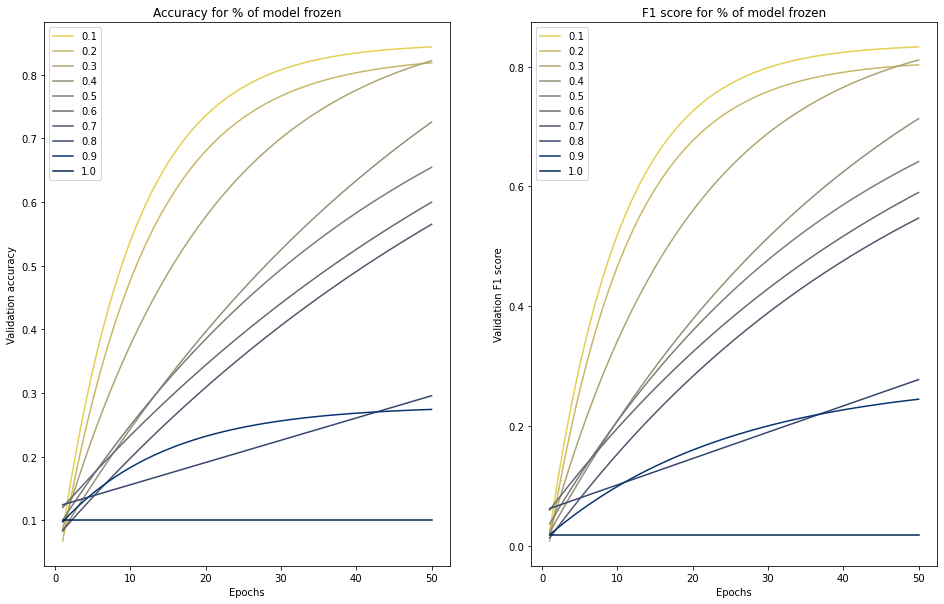

In [15]:
_, fig = plot_results()
fig.savefig('signature_hit/during_training.svg')